
# PhysioNet Motor Imagery EEG - Comprehensive EDA

This notebook builds a subject-wise and run-wise exploratory data analysis for the PhysioNet EEG Motor Movement/Imagery dataset, focusing on data cleanliness, per-person characteristics, and cues for downstream channel selection and modeling.



## Analysis roadmap
- Inventory the EDF files per subject/run and capture dataset metadata
- Extract per-run signal quality, amplitude, and spectral statistics with MNE
- Visualise trial distributions, channel variability, and frequency content (matplotlib/seaborn/plotly)
- Flag anomalous or potentially corrupted recordings and summarise per-subject health
- Provide interactive utilities for deeper inspection and exportable summaries for modelling pipelines


In [59]:

import os
import gc
from pathlib import Path
from functools import lru_cache

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

from tqdm.auto import tqdm

import mne

plt.style.use("seaborn-v0_8")
sns.set_context("notebook", font_scale=1.1)
pio.renderers.default = "notebook_connected"
mne.set_log_level("WARNING")
pd.options.display.float_format = lambda x: f"{x:0.3f}"


In [60]:

DATA_ROOT = Path('data/physionet/files')
DERIVED_DIR = DATA_ROOT.parent / 'derived'
DERIVED_DIR.mkdir(parents=True, exist_ok=True)
RUN_SUMMARY_CACHE = DERIVED_DIR / 'run_summary.pkl'
ERROR_LOG_CACHE = DERIVED_DIR / 'run_summary_errors.json'

assert DATA_ROOT.exists(), f"Expected PhysioNet files under {DATA_ROOT.as_posix()}"
SUBJECT_IDS = sorted(p.name for p in DATA_ROOT.iterdir() if p.is_dir())
print(f"Detected {len(SUBJECT_IDS)} subjects")
SUBJECT_IDS[:10]


Detected 109 subjects


['S001',
 'S002',
 'S003',
 'S004',
 'S005',
 'S006',
 'S007',
 'S008',
 'S009',
 'S010']


## Run metadata reference

Run identifiers (R01-R14) follow the convention from the PhysioNet EEG Motor Movement/Imagery database. The descriptions below are condensed from the official README; please double-check against updated documentation if the acquisition protocol changes.


In [61]:

RUN_METADATA = {
    'R01': {'session': 'baseline', 'category': 'resting_state', 'task': 'Baseline eyes open'},
    'R02': {'session': 'baseline', 'category': 'resting_state', 'task': 'Baseline eyes closed'},
    'R03': {'session': 'run_1', 'category': 'motor_execution', 'task': 'Open/close left fist (executed)'},
    'R04': {'session': 'run_1', 'category': 'motor_execution', 'task': 'Open/close right fist (executed)'},
    'R05': {'session': 'run_1', 'category': 'motor_execution', 'task': 'Open/close both fists (executed)'},
    'R06': {'session': 'run_1', 'category': 'motor_execution', 'task': 'Open/close both feet (executed)'},
    'R07': {'session': 'run_2', 'category': 'motor_imagery', 'task': 'Imagine left fist'},
    'R08': {'session': 'run_2', 'category': 'motor_imagery', 'task': 'Imagine right fist'},
    'R09': {'session': 'run_2', 'category': 'motor_imagery', 'task': 'Imagine both fists'},
    'R10': {'session': 'run_2', 'category': 'motor_imagery', 'task': 'Imagine both feet'},
    'R11': {'session': 'run_3', 'category': 'motor_execution', 'task': 'Alternate fists and feet (executed)'},
    'R12': {'session': 'run_3', 'category': 'motor_execution', 'task': 'Alternate fists and feet (executed, repeat)'},
    'R13': {'session': 'run_3', 'category': 'motor_imagery', 'task': 'Alternate fists and feet (imagery)'},
    'R14': {'session': 'run_3', 'category': 'motor_imagery', 'task': 'Alternate fists and feet (imagery, repeat)'},
}

RUN_METADATA


{'R01': {'session': 'baseline',
  'category': 'resting_state',
  'task': 'Baseline eyes open'},
 'R02': {'session': 'baseline',
  'category': 'resting_state',
  'task': 'Baseline eyes closed'},
 'R03': {'session': 'run_1',
  'category': 'motor_execution',
  'task': 'Open/close left fist (executed)'},
 'R04': {'session': 'run_1',
  'category': 'motor_execution',
  'task': 'Open/close right fist (executed)'},
 'R05': {'session': 'run_1',
  'category': 'motor_execution',
  'task': 'Open/close both fists (executed)'},
 'R06': {'session': 'run_1',
  'category': 'motor_execution',
  'task': 'Open/close both feet (executed)'},
 'R07': {'session': 'run_2',
  'category': 'motor_imagery',
  'task': 'Imagine left fist'},
 'R08': {'session': 'run_2',
  'category': 'motor_imagery',
  'task': 'Imagine right fist'},
 'R09': {'session': 'run_2',
  'category': 'motor_imagery',
  'task': 'Imagine both fists'},
 'R10': {'session': 'run_2',
  'category': 'motor_imagery',
  'task': 'Imagine both feet'},
 '


## Inventory check
Count the available runs per subject and highlight any missing EDFs so that we know which people might need attention before modelling.


In [62]:

from collections import defaultdict

inventory_records = []
missing_records = []
for subject in SUBJECT_IDS:
    subject_dir = DATA_ROOT / subject
    subject_runs = sorted(subject_dir.glob('*.edf'))
    available = {path.stem[-3:]: path for path in subject_runs}
    for run_id in [f'R{idx:02d}' for idx in range(1, 15)]:
        record = {
            'subject': subject,
            'run': run_id,
            'available': run_id in available,
            'file': available.get(run_id)
        }
        if run_id in RUN_METADATA:
            record.update(RUN_METADATA[run_id])
        inventory_records.append(record)
        if run_id not in available:
            missing_records.append({'subject': subject, 'run': run_id})

inventory_df = pd.DataFrame(inventory_records)
missing_df = pd.DataFrame(missing_records)

print(f"Missing runs: {len(missing_df)} (out of {len(SUBJECT_IDS) * 14})")
inventory_df.head()


Missing runs: 0 (out of 1526)


,subject,run,available,file,session,category,task
0,S001,R01,True,data\physionet\files\S001\S001R01.edf,baseline,resting_state,Baseline eyes open
1,S001,R02,True,data\physionet\files\S001\S001R02.edf,baseline,resting_state,Baseline eyes closed
2,S001,R03,True,data\physionet\files\S001\S001R03.edf,run_1,motor_execution,Open/close left fist (executed)
3,S001,R04,True,data\physionet\files\S001\S001R04.edf,run_1,motor_execution,Open/close right fist (executed)
4,S001,R05,True,data\physionet\files\S001\S001R05.edf,run_1,motor_execution,Open/close both fists (executed)


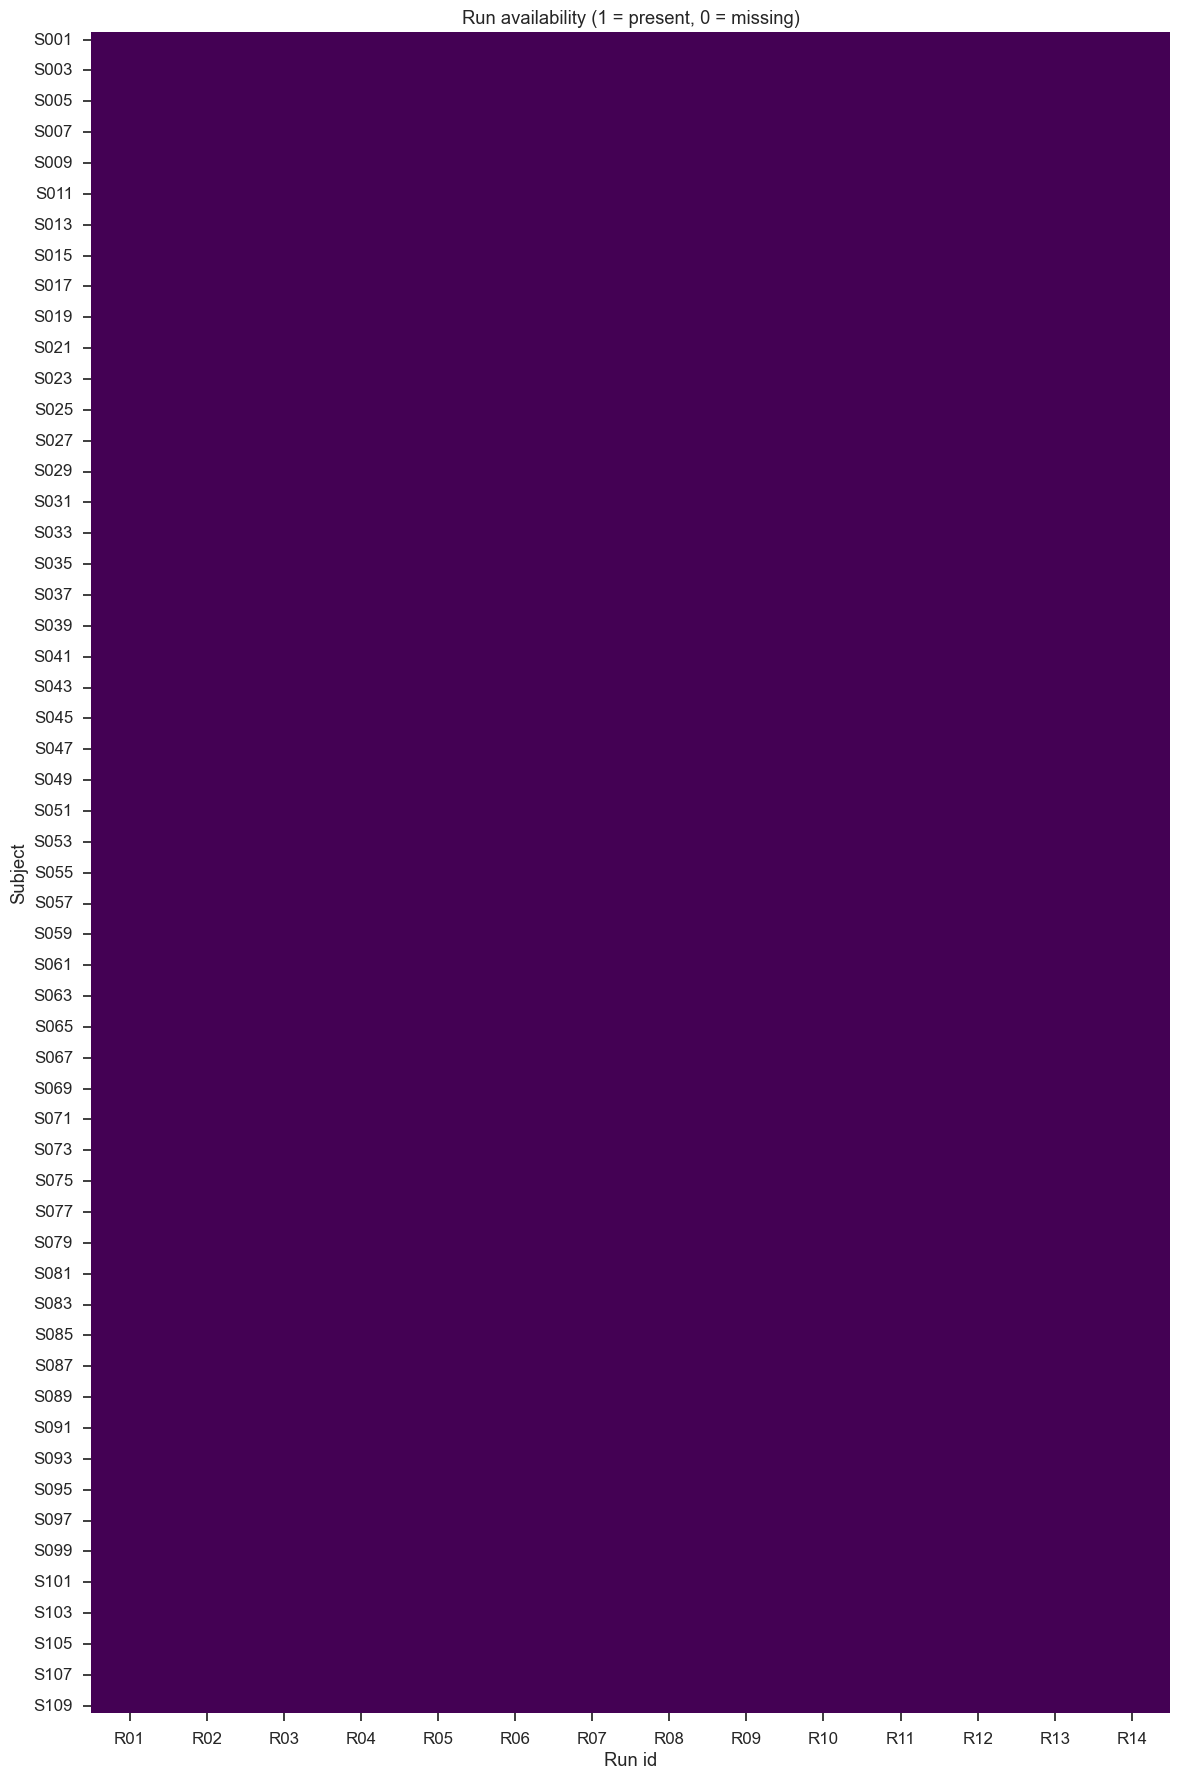

In [63]:

run_matrix = (inventory_df.assign(present=lambda df: df['available'].astype(int))
                               .pivot(index='subject', columns='run', values='present')
                               .fillna(0))
plt.figure(figsize=(12, min(0.25 * len(run_matrix), 18)))
sns.heatmap(run_matrix, cmap='viridis', cbar=False)
plt.title('Run availability (1 = present, 0 = missing)')
plt.xlabel('Run id')
plt.ylabel('Subject')
plt.tight_layout()
plt.show()



### Helper utilities for run-level metrics
The functions below extract quality indicators (channel variance, clipping, spectral balance) and event statistics from each EDF file. We cache results to disk so the heavy lifting only runs once.


In [64]:
import warnings
from typing import Dict, Any

EEG_DECIM_FOR_STATS = 10
EEG_DECIM_FOR_PSD = 2
FLAT_STD_THRESHOLD_UV = 0.5
NOISY_STD_THRESHOLD_UV = 120.0
CLIP_THRESHOLD_UV = 200.0
BAND_DEFS = {
    'delta': (1.0, 4.0),
    'theta': (4.0, 8.0),
    'alpha': (8.0, 13.0),
    'beta': (13.0, 30.0),
    'gamma': (30.0, 45.0),
}

@lru_cache(maxsize=256)
def _load_raw_cache(edf_path: str) -> mne.io.BaseRaw:
    raw = mne.io.read_raw_edf(edf_path, preload=True, verbose='ERROR')
    cleaned_names = {name: name.rstrip('.') for name in raw.ch_names}
    raw.rename_channels(cleaned_names)
    eeg_picks = mne.pick_types(raw.info, eeg=True)
    raw.pick(eeg_picks)
    raw.set_montage('standard_1020', on_missing='ignore', match_case=False)
    return raw


def summarize_run(edf_path: Path) -> Dict[str, Any]:
    edf_path = Path(edf_path)
    run_id = edf_path.stem[-3:]
    subject_id = edf_path.parent.name
    meta = RUN_METADATA.get(run_id, {})

    raw = _load_raw_cache(str(edf_path))
    raw_copy = raw.copy()

    sfreq = float(raw_copy.info['sfreq'])
    duration = float(raw_copy.times[-1])
    eeg_names = raw_copy.ch_names

    with warnings.catch_warnings():
        warnings.simplefilter('ignore', category=RuntimeWarning)
        data_full = raw_copy.get_data()
    data_uv = data_full[:, ::EEG_DECIM_FOR_STATS] * 1e6

    channel_std = data_uv.std(axis=1)
    channel_ptp = data_uv.ptp(axis=1)

    flat_channels = [name for name, std in zip(eeg_names, channel_std) if std < FLAT_STD_THRESHOLD_UV]
    noisy_channels = [name for name, std in zip(eeg_names, channel_std) if std > NOISY_STD_THRESHOLD_UV]
    clip_fraction = float((np.abs(data_uv) > CLIP_THRESHOLD_UV).mean())

    events, event_id = mne.events_from_annotations(raw_copy, verbose='ERROR')
    event_counts = {label: int((events[:, 2] == code).sum()) for label, code in event_id.items()}

    psd_raw = raw_copy.copy()
    target_sfreq = max(sfreq / EEG_DECIM_FOR_PSD, 80.0)
    if abs(target_sfreq - sfreq) > 1e-6:
        psd_raw.resample(target_sfreq, npad='auto')

    nyquist = target_sfreq / 2.0
    fmax_psd = min(60.0, nyquist - 1.0)
    psd = psd_raw.compute_psd(method='welch', fmin=1.0, fmax=fmax_psd, n_fft=512,
                              n_overlap=256, verbose='ERROR')
    psd_data = psd.get_data()
    freqs = psd.freqs
    total_band_mask = (freqs >= 1.0) & (freqs <= 45.0)
    total_power = psd_data[:, total_band_mask].sum(axis=1)
    total_power[total_power == 0] = np.nan

    band_features = {}
    for band, (fmin, fmax) in BAND_DEFS.items():
        mask = (freqs >= fmin) & (freqs < fmax)
        band_power = psd_data[:, mask].sum(axis=1)
        band_ratio = band_power / total_power
        band_features[f'band_{band}_rel_power_mean'] = float(np.nanmean(band_ratio))
        band_features[f'band_{band}_rel_power_std'] = float(np.nanstd(band_ratio))

    line_mask = (freqs >= 58.0) & (freqs <= 62.0)
    beta_mask = (freqs >= 13.0) & (freqs <= 30.0)
    line_power = float(np.nanmean(psd_data[:, line_mask])) if np.any(line_mask) else np.nan
    beta_power = float(np.nanmean(psd_data[:, beta_mask])) if np.any(beta_mask) else np.nan
    if np.isnan(beta_power) or beta_power <= 0:
        line_noise_ratio = np.nan
    else:
        line_noise_ratio = float(line_power / beta_power)

    summary = {
        'subject': subject_id,
        'run': run_id,
        'session': meta.get('session', 'unknown'),
        'category': meta.get('category', 'unknown'),
        'task': meta.get('task', 'unknown'),
        'sfreq': sfreq,
        'n_channels': len(eeg_names),
        'duration_s': duration,
        'mean_channel_std_uv': float(np.mean(channel_std)),
        'median_channel_std_uv': float(np.median(channel_std)),
        'p90_channel_std_uv': float(np.percentile(channel_std, 90)),
        'max_channel_std_uv': float(np.max(channel_std)),
        'p95_channel_ptp_uv': float(np.percentile(channel_ptp, 95)),
        'max_channel_ptp_uv': float(np.max(channel_ptp)),
        'clip_fraction_over_200uv': clip_fraction,
        'max_abs_signal_uv': float(np.max(np.abs(data_uv))),
        'flat_channel_count': len(flat_channels),
        'noisy_channel_count': len(noisy_channels),
        'flat_channels': flat_channels,
        'noisy_channels': noisy_channels,
        'events_total': int(events.shape[0]),
        'events_rest': event_counts.get('T0', 0),
        'events_label_1': event_counts.get('T1', 0),
        'events_label_2': event_counts.get('T2', 0),
        'line_noise_ratio': line_noise_ratio,
        'cache_key': str(edf_path.relative_to(DATA_ROOT.parent)),
    }
    summary.update(band_features)
    return summary

In [65]:
def build_run_summary(subject_subset=None, force_recompute=False):
    subject_list = SUBJECT_IDS if subject_subset is None else list(subject_subset)
    if RUN_SUMMARY_CACHE.exists() and not force_recompute:
        run_df = pd.read_pickle(RUN_SUMMARY_CACHE)
        error_df = pd.read_json(ERROR_LOG_CACHE) if ERROR_LOG_CACHE.exists() else pd.DataFrame()
        if 'subject' in run_df.columns:
            existing_subjects = set(run_df['subject'].unique())
        else:
            existing_subjects = set()
        if run_df.empty or not set(subject_list).issubset(existing_subjects):
            print('Cached summary incomplete or empty - recomputing from scratch')
        else:
            print('Loaded cached summaries from disk')
            return run_df[run_df['subject'].isin(subject_list)].reset_index(drop=True), error_df

    records = []
    errors = []
    for subject in tqdm(subject_list, desc='Summarising runs'):
        subject_dir = DATA_ROOT / subject
        for edf_path in sorted(subject_dir.glob('*.edf')):
            try:
                records.append(summarize_run(edf_path))
            except Exception as exc:
                errors.append({
                    'subject': subject,
                    'run': edf_path.stem[-3:],
                    'file': str(edf_path),
                    'error': repr(exc)
                })
    run_df = pd.DataFrame(records)
    error_df = pd.DataFrame(errors)
    if subject_subset is None:
        run_df.to_pickle(RUN_SUMMARY_CACHE)
        error_df.to_json(ERROR_LOG_CACHE, orient='records', indent=2)
        print(f'Persisted run summary cache to {RUN_SUMMARY_CACHE}')
    return run_df, error_df



### Build or load run-level summaries
Set SUBJECT_FILTER if you want to prototype on a smaller slice before processing the full cohort.


In [66]:
SUBJECT_FILTER = None  # e.g. ['S001', 'S010'] for quick debugging
RUN_DF, ERROR_DF = build_run_summary(subject_subset=SUBJECT_FILTER, force_recompute=False)
if RUN_DF.empty:
    RUN_DF, ERROR_DF = build_run_summary(subject_subset=SUBJECT_FILTER, force_recompute=True)
RUN_DF.head()


Summarising runs: 100%|██████████| 109/109 [11:16<00:00,  6.21s/it]

Persisted run summary cache to data\physionet\derived\run_summary.pkl


,subject,run,session,category,task,sfreq,n_channels,duration_s,mean_channel_std_uv,median_channel_std_uv,...,band_delta_rel_power_mean,band_delta_rel_power_std,band_theta_rel_power_mean,band_theta_rel_power_std,band_alpha_rel_power_mean,band_alpha_rel_power_std,band_beta_rel_power_mean,band_beta_rel_power_std,band_gamma_rel_power_mean,band_gamma_rel_power_std
0,S001,R01,baseline,resting_state,Baseline eyes open,160.000,64,60.994,56.077,52.453,...,0.584,0.101,0.158,0.031,0.112,0.035,0.125,0.053,0.020,0.015
1,S001,R02,baseline,resting_state,Baseline eyes closed,160.000,64,60.994,52.818,50.629,...,0.330,0.105,0.133,0.037,0.388,0.135,0.130,0.039,0.019,0.017
2,S001,R03,run_1,motor_execution,Open/close left fist (executed),160.000,64,124.994,58.346,52.638,...,0.584,0.107,0.160,0.029,0.107,0.039,0.127,0.056,0.022,0.016
3,S001,R04,run_1,motor_execution,Open/close right fist (executed),160.000,64,124.994,52.817,52.675,...,0.551,0.079,0.170,0.029,0.113,0.032,0.140,0.051,0.027,0.018
4,S001,R05,run_1,motor_execution,Open/close both fists (executed),160.000,64,124.994,55.645,51.974,...,0.582,0.111,0.159,0.027,0.098,0.037,0.133,0.061,0.028,0.020


In [67]:
if RUN_SUMMARY_CACHE.exists():
    RUN_SUMMARY_CACHE.unlink()
    print(f'Deleted cached summary: {RUN_SUMMARY_CACHE}')
if ERROR_LOG_CACHE.exists():
    ERROR_LOG_CACHE.unlink()
    print(f'Deleted error log: {ERROR_LOG_CACHE}')
print('Cache cleared. Will force recomputation.')

Deleted cached summary: data\physionet\derived\run_summary.pkl
Deleted error log: data\physionet\derived\run_summary_errors.json
Cache cleared. Will force recomputation.


In [68]:

print(f"Runs processed: {len(RUN_DF)}")
if not ERROR_DF.empty:
    display(ERROR_DF)
else:
    print('No read errors encountered')


Runs processed: 1526
No read errors encountered



## Event distribution and balance
Understanding how many trials per cue exist for each subject/run helps prioritise reliable data for model training.


In [69]:

trial_cols = ['events_rest', 'events_label_1', 'events_label_2']
trial_summary = (RUN_DF[['subject', 'run'] + trial_cols]
                 .set_index(['subject', 'run'])
                 .fillna(0)
                 .astype(int))
trial_summary.head()


events_rest  events_label_1  events_label_2
subject run                                             
S001    R01            1               0               0
        R02            1               0               0
        R03           15               8               7
        R04           15               8               7
        R05           15               8               7

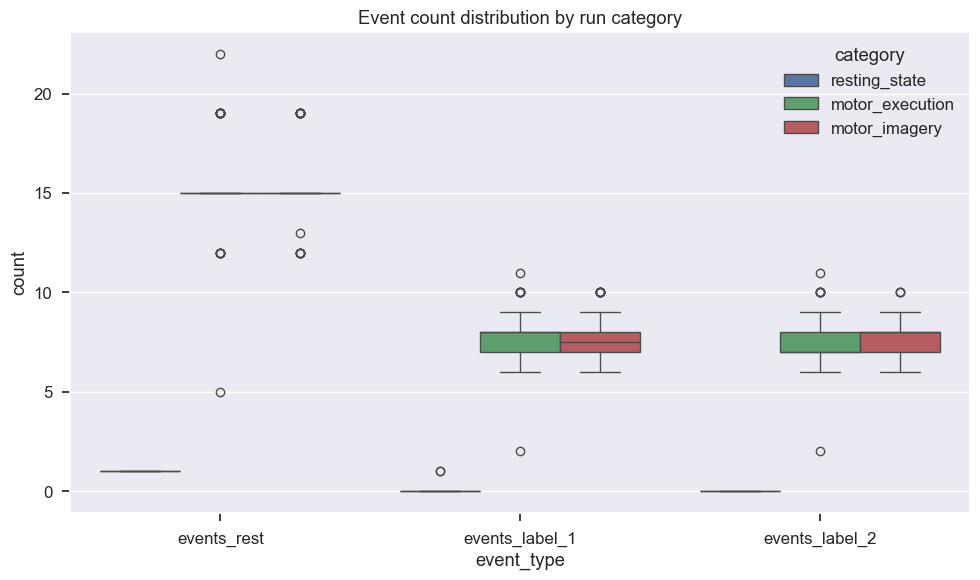

In [70]:

trial_long = RUN_DF.melt(id_vars=['subject', 'run', 'category'],
                         value_vars=trial_cols,
                         var_name='event_type', value_name='count')
plt.figure(figsize=(10, 6))
sns.boxplot(data=trial_long, x='event_type', y='count', hue='category')
plt.title('Event count distribution by run category')
plt.tight_layout()
plt.show()


In [71]:

pivot_counts = (RUN_DF.pivot_table(index='subject', columns='run', values='events_total', aggfunc='sum')
                       .fillna(0))
fig = px.imshow(pivot_counts,
                labels=dict(color='Events'),
                color_continuous_scale='Plasma',
                title='Total events per subject/run')
fig.update_layout(height=max(400, 12 * len(pivot_counts)))
fig.show()



## Signal amplitude and stability
Channel-wise variance reveals drifts, flatlines, or sensor pops that break consistency across recordings.


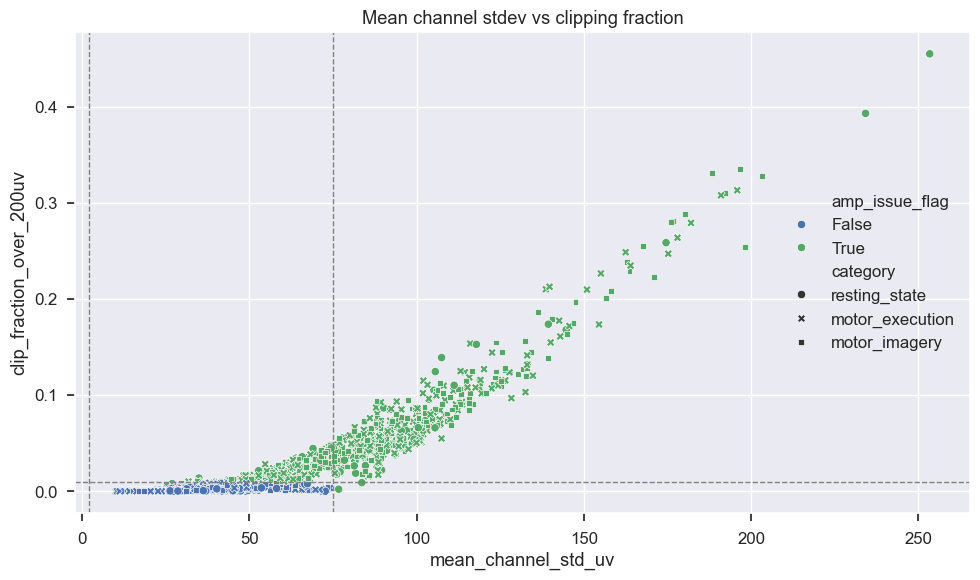

In [72]:

RUN_DF['has_flat_issue'] = RUN_DF['flat_channel_count'] > 0
RUN_DF['has_noisy_issue'] = RUN_DF['noisy_channel_count'] > 0
RUN_DF['amp_issue_flag'] = (
    RUN_DF['has_flat_issue'] |
    RUN_DF['has_noisy_issue'] |
    (RUN_DF['mean_channel_std_uv'] < 2.0) |
    (RUN_DF['mean_channel_std_uv'] > 75.0) |
    (RUN_DF['clip_fraction_over_200uv'] > 0.01)
)

plt.figure(figsize=(10,6))
sns.scatterplot(data=RUN_DF,
                x='mean_channel_std_uv', y='clip_fraction_over_200uv',
                hue='amp_issue_flag', style='category')
plt.axvline(2.0, linestyle='--', color='grey', linewidth=1)
plt.axvline(75.0, linestyle='--', color='grey', linewidth=1)
plt.axhline(0.01, linestyle='--', color='grey', linewidth=1)
plt.title('Mean channel stdev vs clipping fraction')
plt.tight_layout()
plt.show()


In [73]:

fig = px.box(RUN_DF, x='category', y='mean_channel_std_uv', color='category', title='Channel variance by category')
fig.update_traces(notched=True)
fig.show()



## Frequency-domain characteristics
Inspect relative band power and highlight elevated line noise or abnormal spectra.


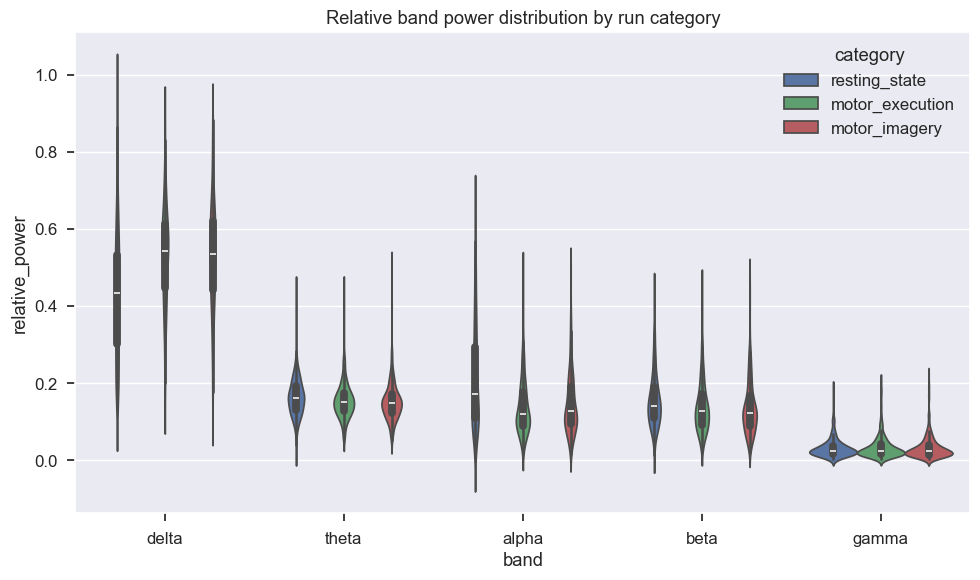

In [74]:

band_cols = [col for col in RUN_DF.columns if col.startswith('band_') and col.endswith('_mean')]
band_long = RUN_DF.melt(id_vars=['subject', 'run', 'category'],
                        value_vars=band_cols,
                        var_name='band', value_name='relative_power')
band_long['band'] = band_long['band'].str.replace('band_', '').str.replace('_rel_power_mean', '')
plt.figure(figsize=(10,6))
sns.violinplot(data=band_long, x='band', y='relative_power', hue='category', split=False)
plt.title('Relative band power distribution by run category')
plt.tight_layout()
plt.show()


In [75]:

fig = px.scatter(RUN_DF,
                 x='line_noise_ratio', y='band_alpha_rel_power_mean',
                 color='category', symbol='amp_issue_flag',
                 hover_data=['subject', 'run', 'task'],
                 title='Line noise vs alpha power balance')
fig.add_vline(x=2.0, line_dash='dash', line_color='red', annotation_text='line/noise threshold')
fig.show()



### Example topography
Visualise alpha relative power for a representative run to spot spatial artefacts (frontal eye movement, occipital alpha, etc.).


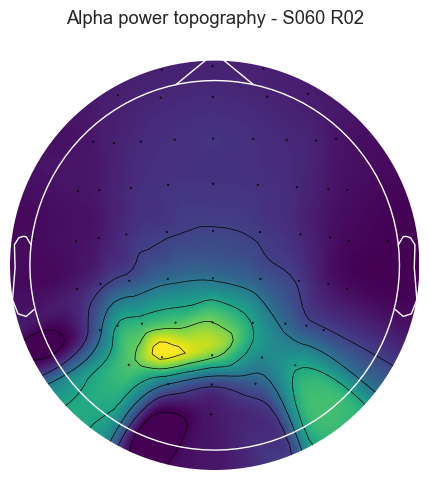

In [76]:
from mne.viz import plot_topomap

example_row = RUN_DF.sort_values('band_alpha_rel_power_mean', ascending=False).iloc[0]
example_path = DATA_ROOT / example_row['subject'] / f"{example_row['subject']}{example_row['run']}.edf"
example_raw = _load_raw_cache(str(example_path)).copy()

example_sfreq = example_raw.info['sfreq']
example_target_sfreq = max(example_sfreq / EEG_DECIM_FOR_PSD, 80.0)
if abs(example_target_sfreq - example_sfreq) > 1e-6:
    example_raw.resample(example_target_sfreq, npad='auto')

example_nyquist = example_target_sfreq / 2.0
example_fmax = min(60.0, example_nyquist - 1.0)

psd = example_raw.compute_psd(method='welch', fmin=1.0, fmax=example_fmax, n_fft=1024,
                             n_overlap=512, verbose='ERROR')
freqs = psd.freqs
data = psd.get_data()
alpha_mask = (freqs >= 8.0) & (freqs <= 13.0)
alpha_power = data[:, alpha_mask].mean(axis=1)
fig, ax = plt.subplots(figsize=(5,5))
plot_topomap(alpha_power, example_raw.info, axes=ax, show=False, cmap='viridis')
ax.set_title(f"Alpha power topography - {example_row['subject']} {example_row['run']}")
plt.tight_layout()
plt.show()


## Anomaly detection and subject-level health
Aggregate run metrics into subject profiles and flag people with repeated issues.


In [77]:
import numpy as np
from scipy.stats import zscore

numeric_cols = [
    "mean_channel_std_uv", "median_channel_std_uv", "p90_channel_std_uv",
    "max_channel_std_uv", "p95_channel_ptp_uv", "max_channel_ptp_uv",
    "clip_fraction_over_200uv", "max_abs_signal_uv", "band_alpha_rel_power_mean",
    "band_beta_rel_power_mean", "band_theta_rel_power_mean", "line_noise_ratio",
]

# keep only complete rows
z_df = RUN_DF[["subject", "run"] + numeric_cols].dropna()

# z-score entire numeric block at once
z_values = zscore(z_df[numeric_cols].to_numpy(dtype=float), axis=0, nan_policy="omit")
if isinstance(z_values, np.ma.MaskedArray):
    z_values = z_values.filled(np.nan)

z_scores = pd.DataFrame(z_values, columns=numeric_cols, index=z_df.index)

# compute max abs z and merge back
z_df = z_df.assign(max_abs_z=np.abs(z_scores).max(axis=1))
RUN_DF = RUN_DF.merge(z_df[["subject", "run", "max_abs_z"]], on=["subject", "run"], how="left")
RUN_DF["zscore_flag"] = RUN_DF["max_abs_z"] > 3.0


In [78]:

subject_summary = (
    RUN_DF.groupby('subject').agg({
        'run': 'nunique',
        'category': lambda s: ', '.join(sorted(set(s))),
        'duration_s': 'sum',
        'events_total': 'sum',
        'events_label_1': 'sum',
        'events_label_2': 'sum',
        'mean_channel_std_uv': ['median', 'min', 'max'],
        'clip_fraction_over_200uv': ['mean', 'max'],
        'line_noise_ratio': ['median', 'max'],
        'flat_channel_count': lambda s: int((s > 0).sum()),
        'noisy_channel_count': lambda s: int((s > 0).sum()),
        'amp_issue_flag': 'sum',
        'zscore_flag': 'sum'
    })
)
subject_summary.columns = ['_'.join(filter(None, col)).strip('_') for col in subject_summary.columns]
subject_summary = subject_summary.rename(columns={
    'run_nunique': 'runs_available',
    'category_<lambda>': 'categories_observed',
    'duration_s_sum': 'total_duration_s',
    'events_total_sum': 'total_events',
    'events_label_1_sum': 'total_label_1',
    'events_label_2_sum': 'total_label_2',
    'mean_channel_std_uv_median': 'median_mean_std_uv',
    'mean_channel_std_uv_min': 'min_mean_std_uv',
    'mean_channel_std_uv_max': 'max_mean_std_uv',
    'clip_fraction_over_200uv_mean': 'avg_clip_fraction',
    'clip_fraction_over_200uv_max': 'max_clip_fraction',
    'line_noise_ratio_median': 'median_line_noise_ratio',
    'line_noise_ratio_max': 'max_line_noise_ratio',
    'flat_channel_count_<lambda>': 'runs_with_flat_channels',
    'noisy_channel_count_<lambda>': 'runs_with_noisy_channels',
    'amp_issue_flag_sum': 'runs_with_amp_issue',
    'zscore_flag_sum': 'runs_with_zscore_outlier'
})
subject_summary['suspect_subject'] = (
    (subject_summary['runs_with_amp_issue'] > 0) |
    (subject_summary['runs_with_zscore_outlier'] > 0) |
    (subject_summary['max_clip_fraction'] > 0.05) |
    (subject_summary['median_line_noise_ratio'] > 2.5)
)
subject_summary.sort_values('runs_with_amp_issue', ascending=False).head()


,runs_available,categories_observed,total_duration_s,total_events,total_label_1,total_label_2,median_mean_std_uv,min_mean_std_uv,max_mean_std_uv,avg_clip_fraction,max_clip_fraction,median_line_noise_ratio,max_line_noise_ratio,runs_with_flat_channels,runs_with_noisy_channels,runs_with_amp_issue,runs_with_zscore_outlier,suspect_subject
subject,,,,,,,,,,,,,,,,,,
S109,14,"motor_execution, motor_imagery, resting_state",1596.913,362,93,87,75.961,57.314,122.563,0.064,0.153,NaN,NaN,0,14,14,0,True
S032,14,"motor_execution, motor_imagery, resting_state",1621.913,362,88,92,101.113,81.769,132.793,0.063,0.124,NaN,NaN,0,13,14,0,True
S086,14,"motor_execution, motor_imagery, resting_state",1621.913,362,88,92,84.126,64.965,102.863,0.044,0.076,NaN,NaN,0,14,14,0,True
S059,14,"motor_execution, motor_imagery, resting_state",1597.913,362,90,90,179.168,145.667,253.397,0.282,0.455,NaN,NaN,0,14,14,0,True
S028,14,"motor_execution, motor_imagery, resting_state",1597.913,362,92,88,111.149,100.451,144.711,0.101,0.168,NaN,NaN,0,14,14,0,True


In [79]:

fig = px.scatter(subject_summary.reset_index(),
                 x='median_mean_std_uv', y='median_line_noise_ratio',
                 size='runs_with_amp_issue', color='suspect_subject',
                 hover_data=['subject', 'runs_available', 'avg_clip_fraction'],
                 title='Subject-level signal health overview')
fig.add_hline(y=2.5, line_dash='dash', line_color='red')
fig.add_vline(x=5.0, line_dash='dash', line_color='grey')
fig.show()



## Interactive run explorer
Select any subject/run to inspect the raw waveform (first few seconds) from key sensor sites.


In [80]:

def plot_run_timeseries(subject_id: str, run_id: str, seconds: float = 8.0, channels=None):
    edf_path = DATA_ROOT / subject_id / f"{subject_id}{run_id}.edf"
    if not edf_path.exists():
        raise FileNotFoundError(edf_path)
    raw = _load_raw_cache(str(edf_path)).copy().load_data()
    if channels is None:
        channels = ['C3', 'Cz', 'C4', 'Pz']
    available = [ch for ch in channels if ch in raw.ch_names]
    data = raw.copy().pick_channels(available)
    sfreq = data.info['sfreq']
    stop = int(min(seconds * sfreq, data.n_times))
    array = data.get_data(stop=stop) * 1e6
    time = np.arange(stop) / sfreq
    df = pd.DataFrame({'time_s': np.tile(time, len(available)),
                       'channel': np.repeat(available, stop),
                       'amplitude_uV': array.reshape(len(available) * stop)})
    fig = px.line(df, x='time_s', y='amplitude_uV', color='channel',
                  title=f'{subject_id} {run_id} - first {seconds} s')
    fig.update_layout(xaxis_title='Time (s)', yaxis_title='Amplitude (uV)')
    fig.show()

plot_run_timeseries('S001', 'R03', seconds=6)



## Export artefact flags for downstream modelling
Save run- and subject-level data quality reports so training scripts can filter out problematic recordings (for example, only use subjects with clean signals).


In [81]:

RUN_REPORT_PATH = DERIVED_DIR / 'physionet_run_summary.csv'
SUBJECT_REPORT_PATH = DERIVED_DIR / 'physionet_subject_summary.csv'

RUN_DF.sort_values(['subject', 'run']).to_csv(RUN_REPORT_PATH, index=False)
subject_summary.sort_values('suspect_subject', ascending=False).to_csv(SUBJECT_REPORT_PATH)
print(f'Exported run summary -> {RUN_REPORT_PATH}')
print(f'Exported subject summary -> {SUBJECT_REPORT_PATH}')


Exported run summary -> data\physionet\derived\physionet_run_summary.csv
Exported subject summary -> data\physionet\derived\physionet_subject_summary.csv



## Next steps
- Use subject_summary to exclude people with repeated flat/noisy runs (for example, keep only suspect_subject == False).
- Train per-person models by iterating over clean runs and feeding channel-level features.
- Review ERROR_DF or missing runs to locate genuinely corrupted EDF files that need re-downloading.
